In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, cohen_kappa_score, matthews_corrcoef,
    log_loss, brier_score_loss
)
from sklearn.pipeline import make_pipeline
import joblib
import os
import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Lazy Predict for quick benchmarking
import lazypredict
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
pip install lazypredict

In [ ]:
pip install shap

In [ ]:
# Load data from CSV file

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/Clinical Main Data.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Display the first few rows of the DataFrame

In [7]:
df

,lab_no,sex,age,temperature,Thick Film,Cases,chill_cold,headache,fever,generalized body pain,abdominal pain,Loss of appetite,joint pain,vomiting,nausea,diarrhea
0,LT014233,Male,35,37.50,No Malaria Parasite seen,0,False,True,True,False,False,False,False,True,False,False
1,LT144344,Male,36,37.50,No Malaria Parasite Seen,0,True,False,True,True,False,False,False,False,False,False
2,LT005429,Female,29,36.70,NMPs,0,False,True,False,False,False,False,False,False,False,False
3,LT038865,Female,29,36.10,NMPs,0,False,True,False,True,False,False,False,False,False,False
4,LT095829,Female,30,36.70,NMPs,0,False,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48892,LT243382,Male,37,36.80,NMPs,0,False,False,False,False,False,False,False,False,False,False
48893,LT243389,Female,37,36.90,NMPs,0,False,True,False,False,False,False,False,False,False,False
48894,LT243394,Female,24,37.50,No Malaria Parasite Seen,0,False,False,True,False,False,False,False,False,False,False
48895,LT243729,Female,39,37.00,No Malaria parasite Seen,0,False,True,False,True,False,False,False,False,False,False


In [8]:
print(df.head())

     lab_no     sex  age  temperature                Thick Film  Cases  \
0  LT014233    Male   35        37.50  No Malaria Parasite seen      0   
1  LT144344    Male   36        37.50  No Malaria Parasite Seen      0   
2  LT005429  Female   29        36.70                      NMPs      0   
3  LT038865  Female   29        36.10                      NMPs      0   
4  LT095829  Female   30        36.70                      NMPs      0   

   chill_cold  headache  fever  generalized body pain  abdominal pain  \
0       False      True   True                  False           False   
1        True     False   True                   True           False   
2       False      True  False                  False           False   
3       False      True  False                   True           False   
4       False      True   True                  False           False   

   Loss of appetite  joint pain  vomiting  nausea  diarrhea  
0             False       False      True   False     

In [ ]:
# Define features and target variable

In [9]:
features = [
    'chill_cold', 'headache', 'fever', 'generalized body pain',
    'abdominal pain', 'Loss of appetite', 'joint pain', 'vomiting',
    'nausea', 'diarrhea'
]
target = 'Cases'

In [ ]:
# Convert TRUE/FALSE to 1/0 for binary classification

In [10]:
df['Cases'] = df['Cases'].astype(int)  # Ensure target variable is numeric
df[features] = df[features].astype(int)  # Convert feature columns to numeric

In [ ]:
# Prepare feature matrix X and target vector y

In [11]:
X = df[features]
y = df[target]

In [11]:
# Calculate VIF (Variance Inflation Factor)
X_constant = sm.add_constant(X)
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
vif_df = pd.DataFrame({'Feature': ['Intercept'] + features, 'VIF': vif})
print("VIF Values:")
print(vif_df)

VIF Values:
                  Feature  VIF
0               Intercept 3.22
1              chill_cold 1.02
2                headache 1.06
3                   fever 1.01
4   generalized body pain 1.03
5          abdominal pain 1.02
6        Loss of appetite 1.01
7              joint pain 1.01
8                vomiting 1.04
9                  nausea 1.02
10               diarrhea 1.02


## Feature engineering


Feature Importances:
                 Feature  Random Forest Importance  \
2                  fever                      0.23   
1               headache                      0.22   
0             chill_cold                      0.11   
7               vomiting                      0.10   
3  generalized body pain                      0.07   
8                 nausea                      0.06   
5       Loss of appetite                      0.06   
4         abdominal pain                      0.06   
6             joint pain                      0.05   
9               diarrhea                      0.04   

   Logistic Regression Coefficient  
2                             0.77  
1                             0.63  
0                             0.64  
7                             0.38  
3                             0.26  
8                             0.17  
5                             0.07  
4                             0.24  
6                             0.31  
9            

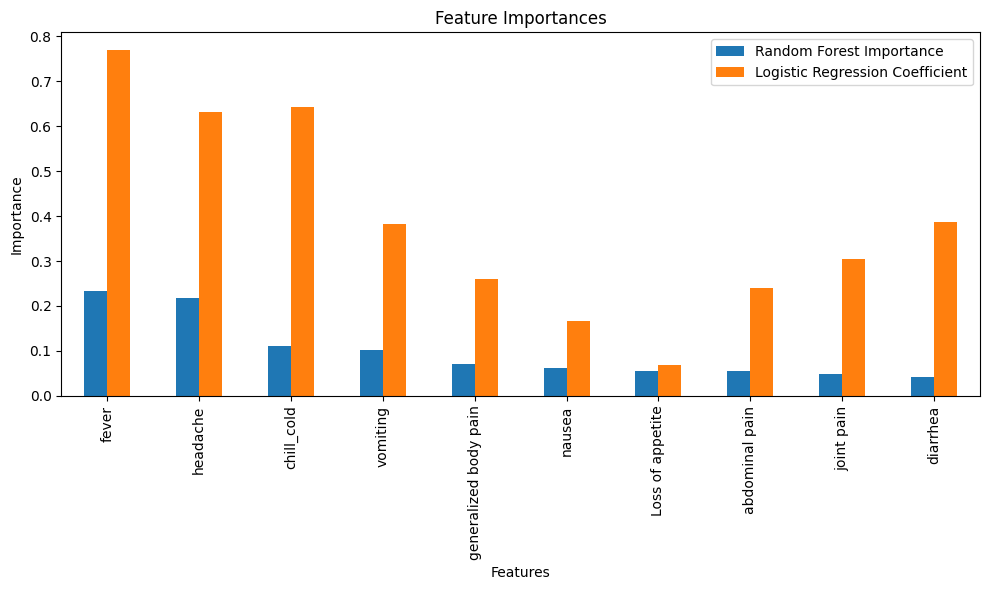

In [12]:
# Random Forest Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
rf_importances = rf_model.feature_importances_

# Logistic Regression Coefficients
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X, y)
log_reg_coefficients = np.abs(log_reg_model.coef_[0])

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Random Forest Importance': rf_importances,
    'Logistic Regression Coefficient': log_reg_coefficients
}).sort_values(by='Random Forest Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# Plot Feature Importances
importance_df.set_index('Feature').plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# SHAP Values for Feature Interpretability
#explainer = shap.Explainer(rf_model, X)
#shap_values = explainer(X)

# Plot SHAP summary plot
#shap.summary_plot(shap_values, X, plot_type="bar")

In [1]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=20)

clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

NameError: name 'train_test_split' is not defined

In [ ]:
# Split data into training and testing sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


In [ ]:
# Define models

In [ ]:
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(probability=True)),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [ ]:
# Directory to save models

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/models'
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
# Function to plot ROC curve and calculate AUC

In [ ]:
def plot_roc_auc(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

    return auc

In [ ]:
# Dictionary to store performance metrics

In [ ]:
model_performance = {}

In [ ]:
# Train, evaluate, and save models

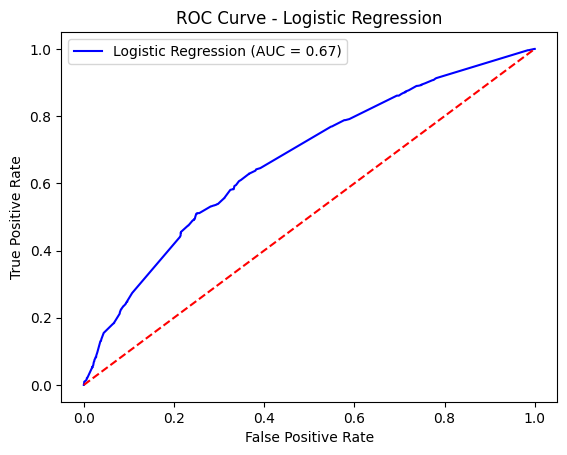

Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8190
           1       0.00      0.00      0.00      1590

    accuracy                           0.84      9780
   macro avg       0.42      0.50      0.46      9780
weighted avg       0.70      0.84      0.76      9780

Confusion Matrix:
[[8188    2]
 [1590    0]]
--------------------------------------------------
Model saved to: /content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/models/Logistic_Regression.pkl


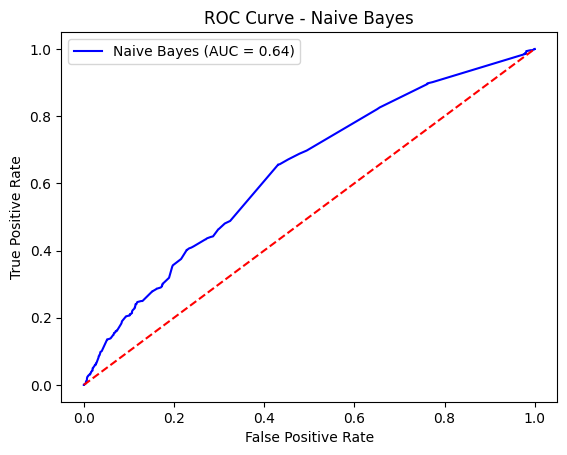

Model: Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      8190
           1       0.28      0.23      0.25      1590

    accuracy                           0.78      9780
   macro avg       0.57      0.56      0.56      9780
weighted avg       0.76      0.78      0.77      9780

Confusion Matrix:
[[7266  924]
 [1227  363]]
--------------------------------------------------
Model saved to: /content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/models/Naive_Bayes.pkl


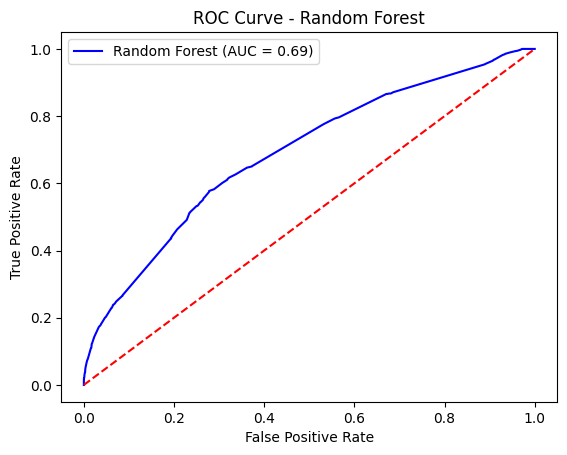

Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      8190
           1       0.68      0.06      0.12      1590

    accuracy                           0.84      9780
   macro avg       0.77      0.53      0.52      9780
weighted avg       0.82      0.84      0.78      9780

Confusion Matrix:
[[8143   47]
 [1488  102]]
--------------------------------------------------
Model saved to: /content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/models/Random_Forest.pkl


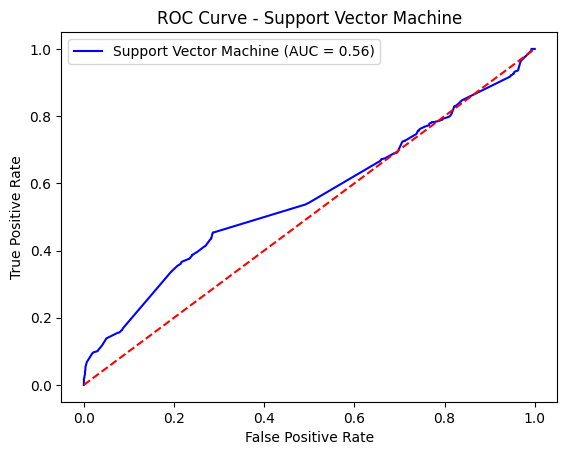

Model: Support Vector Machine
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8190
           1       0.73      0.05      0.09      1590

    accuracy                           0.84      9780
   macro avg       0.79      0.52      0.50      9780
weighted avg       0.83      0.84      0.78      9780

Confusion Matrix:
[[8162   28]
 [1514   76]]
--------------------------------------------------
Model saved to: /content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/models/Support_Vector_Machine.pkl


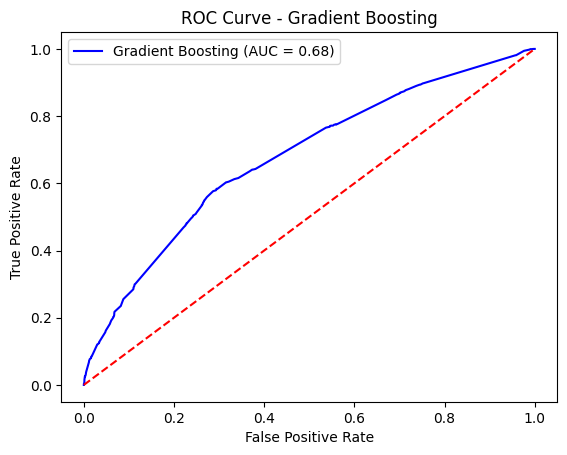

Model: Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8190
           1       0.67      0.03      0.05      1590

    accuracy                           0.84      9780
   macro avg       0.75      0.51      0.48      9780
weighted avg       0.81      0.84      0.77      9780

Confusion Matrix:
[[8170   20]
 [1550   40]]
--------------------------------------------------
Model saved to: /content/drive/MyDrive/Colab Notebooks/Malaria modeling and Prediction/clinical/models/Gradient_Boosting.pkl


In [ ]:
# Train, evaluate, and save models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability predictions for log loss and Brier score

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_prob)
    brier = brier_score_loss(y_test, y_pred_prob)
    cv_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    auc = plot_roc_auc(model, X_test, y_test, name) if hasattr(model, "predict_proba") else None

    model_performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'Log Loss': logloss,
        'Brier Score': brier,
        'CV Accuracy': cv_accuracy
    }

    print(f"Model: {name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

    model_path = os.path.join(model_save_path, f'{name.replace(" ", "_")}.pkl')
    joblib.dump(model, model_path)
    print(f"Model saved to: {model_path}")
    print("=" * 50)

In [ ]:
# Compare the performance of all models

In [ ]:
comparison_df = pd.DataFrame(model_performance).T
print("\nComparison of Model Performance:")
print(comparison_df)


Comparison of Model Performance:
                        Accuracy  Precision    Recall  F1 Score       AUC  \
Logistic Regression     0.837219   0.701250  0.837219  0.763226  0.669219   
Naive Bayes             0.780061   0.762294  0.780061  0.770477  0.635367   
Random Forest           0.842843   0.819557  0.842843  0.783451  0.689798   
Support Vector Machine  0.842331   0.825198  0.842331  0.779734  0.557872   
Gradient Boosting       0.839468   0.812268  0.839468  0.771897  0.677148   

                        Cohen Kappa       MCC  Log Loss  Brier Score  \
Logistic Regression       -0.000409 -0.006302  0.419660     0.129213   
Naive Bayes                0.125086  0.126047  0.558976     0.169547   
Random Forest              0.087917  0.172208  0.405441     0.124270   
Support Vector Machine     0.071187  0.159648  0.434045     0.132291   
Gradient Boosting          0.037100  0.107337  0.414757     0.127376   

                        CV Accuracy  
Logistic Regression        0.842

In [ ]:
# Identify the best-performing model based on F1 Score

In [ ]:
best_model = comparison_df['F1 Score'].idxmax()
print(f"\nBest-performing model: {best_model} based on F1 Score")


Best-performing model: Random Forest based on F1 Score


In [ ]:
# ANOVA-like test for Logistic Regression

In [ ]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print("\nLogistic Regression Summary (ANOVA-like):")
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.412581
         Iterations 6

Logistic Regression Summary (ANOVA-like):
                           Logit Regression Results                           
Dep. Variable:                  Cases   No. Observations:                39117
Model:                          Logit   Df Residuals:                    39106
Method:                           MLE   Df Model:                           10
Date:                Sun, 22 Sep 2024   Pseudo R-squ.:                 0.04954
Time:                        12:22:46   Log-Likelihood:                -16139.
converged:                       True   LL-Null:                       -16980.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.6128      0.031

# Predicting already Know Cases  

In [ ]:
# Load the best-performing model (update the model name based on your previous comparison)

In [ ]:
best_model_name = 'Random Forest'  # Replace with your best model name
model_path = r"C:\Users\victor.idakwo\Documents\ehealth Africa\TASK\Malaria Prediction\Final Main Analysis\Clinical\models\Random_Forest.pkl"  # Adjust if necessary
model = joblib.load(model_path)

In [ ]:
# Load new data from Excel

In [ ]:
new_data_path = r"C:\Users\victor.idakwo\Documents\ehealth Africa\TASK\Malaria Prediction\Final Main Analysis\Clinical\Clinical Main Data.xlsx" # Update with your new data file path
new_data = pd.read_excel(new_data_path)

In [ ]:
# Display the first few rows of the new data

In [ ]:
print(new_data.head())

     lab_no     sex  age  temperature                Thick Film  Cases  \
0  LT014233    Male   35         37.5  No Malaria Parasite seen      0   
1  LT144344    Male   36         37.5  No Malaria Parasite Seen      0   
2  LT005429  Female   29         36.7                      NMPs      0   
3  LT038865  Female   29         36.1                      NMPs      0   
4  LT095829  Female   30         36.7                      NMPs      0   

   chill_cold  headache  fever  generalized body pain  abdominal pain  \
0       False      True   True                  False           False   
1        True     False   True                   True           False   
2       False      True  False                  False           False   
3       False      True  False                   True           False   
4       False      True   True                  False           False   

   Loss of appetite  joint pain  vomiting  nausea  diarrhea  
0             False       False      True   False     

In [ ]:
# Define features based on the training data

In [ ]:
features = [
    'chill_cold', 'headache', 'fever', 'generalized body pain',
    'abdominal pain', 'Loss of appetite', 'joint pain', 'vomiting',
    'nausea', 'diarrhea'
]


In [ ]:
# Ensure the new data has the same features as the training data

In [ ]:
X_new = new_data[features]

In [ ]:
# Make predictions

In [ ]:
predictions = model.predict(X_new)

In [ ]:
# Add predictions to the new data DataFrame

In [ ]:
new_data['Predicted Cases'] = predictions

In [ ]:
# Save the results back to Excel

In [ ]:
output_path = r"C:\Users\victor.idakwo\Documents\ehealth Africa\TASK\Malaria Prediction\Final Main Analysis\Clinical\Predictions.xlsx"  # Update output path
new_data.to_excel(output_path, index=False)
print(f"Predictions saved to: {output_path}")

Predictions saved to: C:\Users\victor.idakwo\Documents\ehealth Africa\TASK\Malaria Prediction\Final Main Analysis\Clinical\Predictions.xlsx
